In [169]:
import pandas as pd
import json
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from statannotations.Annotator import Annotator
from pandas.plotting import table
import scienceplots

In [142]:
# Load data
df_auto = pd.read_csv('./project_pipeline/data/disorder.tsv', sep='\t').astype('object')
df_single = pd.read_csv('./project_pipeline/data/single_domain_pae.tsv', sep='\t').astype('object')
df_multi = pd.read_csv('./project_pipeline/data/multi_domain_pae.tsv', sep='\t').astype('object')
cl = pd.read_csv('./project_pipeline/data/classified_files_3.tsv', sep='\t').astype('object')

plt.style.use('science')

In [143]:
sns.set_theme(font_scale=1.25)

# Get the hex codes for the colors so we can assign them to categories
pal = sns.color_palette('Set1')
print(pal.as_hex())

# Set the color palette. Our categories are "Single Domain", "Two-Domain", and "Autoinhibitory"
colors = {'Single Domain': pal[0], 'Two-Domain': pal[1], 'Autoinhibitory': pal[2]}
pal.as_hex()

['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628', '#f781bf', '#999999']


['#e41a1c',
 '#377eb8',
 '#4daf4a',
 '#984ea3',
 '#ff7f00',
 '#ffff33',
 '#a65628',
 '#f781bf',
 '#999999']

Reformat the dataframes

In [144]:
df_pae = df_auto[['uniprot', 'mean_pae_1_1', 'mean_pae_1_2', 'mean_pae_2_2']]

# Remove all rows with multiple regions. Comment this out if you want to see the difference.
for i in range(len(df_single)):
    region = df_single.loc[i, 'region']
    count = region.count('-')
    if count > 1:
        df_single = df_single.drop(i)


# Reformat the singles dataframe
df_single = df_single[['uniprot', 'mean_pae']].dropna()
df_single = df_single.astype({'mean_pae': 'float'})
df_single = df_single.rename(columns={'mean_pae': 'Single Domain'})
df_single_melt = df_single.melt(id_vars=['uniprot'], var_name='region', value_name='mean_pae')

# Reformat all pae dataframe
df_pae = df_pae.rename(columns={'mean_pae_1_1': 'IM', 'mean_pae_1_2': 'IM on FD', 'mean_pae_2_2': 'FD'})
df_pae_melt = df_pae.melt(id_vars=['uniprot'], var_name='region', value_name='mean_pae').drop_duplicates()

# Reformat the multi dataframe
df_multi = df_multi[['uniprot', 'mean_pae_1_1', 'mean_pae_1_2', 'mean_pae_2_2']].dropna().reset_index(drop=True)
df_multi = df_multi.rename(columns={'mean_pae_1_1': 'D1', 'mean_pae_1_2': 'D1 on D2', 'mean_pae_2_2': 'D2'})
df_multi_melt = df_multi.melt(id_vars=['uniprot'], var_name='region', value_name='mean_pae').drop_duplicates()

# Add type column
df_pae_melt['type'] = 'Autoinhibitory'
df_single_melt['type'] = 'Single Domain'
df_multi_melt['type'] = 'Two-Domain'

# Merge all dataframes
df_all = pd.concat([df_single_melt, df_pae_melt, df_multi_melt], ignore_index=True).drop_duplicates()
df_all['mean_pae'] = df_all['mean_pae'].astype('float')

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

IM on FD_Autoinhibitory vs. IM_Autoinhibitory: Mann-Whitney-Wilcoxon test two-sided, P_val:7.968e-14 U_stat=1.173e+04
IM_Autoinhibitory vs. FD_Autoinhibitory: Mann-Whitney-Wilcoxon test two-sided, P_val:4.357e-01 U_stat=8.000e+03
D1 on D2_Two-Domain vs. D1_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:1.595e-07 U_stat=2.312e+03
D1_Two-Domain vs. D2_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:6.310e-03 U_stat=1.903e+03
IM on FD_Autoinhibitory vs. FD_Autoinhibitory: Mann-Whitney-Wilcoxon test two-sided, P_val:3.580e-19 U_stat=1.256e+04
D1 on D2_Two-Domain vs. D2_Two-Domain: Mann-Whitney-Wilcoxon test two-sided, P_val:2.515e-13 U_stat=2.650e+03


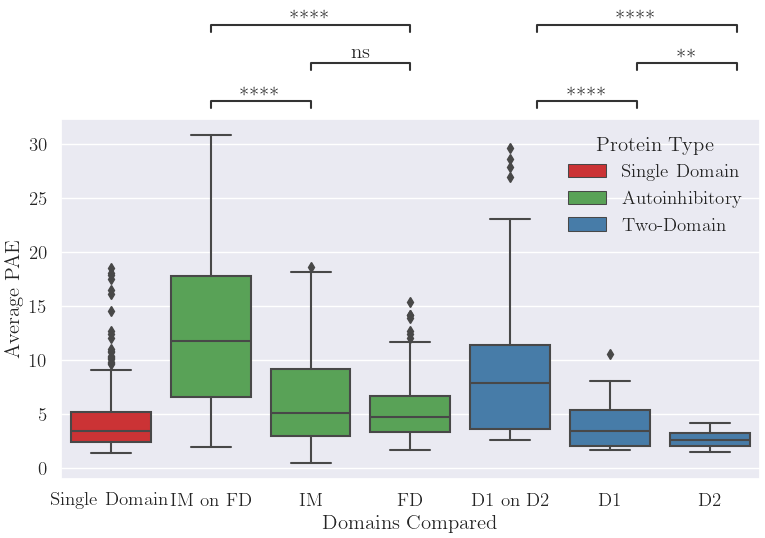

In [145]:
region_order = ['Single Domain', 'IM on FD', 'IM', 'FD', 'D1 on D2', 'D1', 'D2']

f, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(data=df_all, x='region', y='mean_pae', hue='type', order=region_order, ax=ax, palette=colors, dodge=False)
ax.set_xlabel('Domains Compared')
ax.set_ylabel('Average PAE')
ax.legend(title='Protein Type')
plt.style.use('science')

# Annotate statistical significance

pairs = [[('IM on FD', 'Autoinhibitory'), ('IM', 'Autoinhibitory')],
         [('IM on FD', 'Autoinhibitory'), ('FD', 'Autoinhibitory')],
         [('IM', 'Autoinhibitory'), ('FD', 'Autoinhibitory')],
         [('D1 on D2', 'Two-Domain'), ('D1', 'Two-Domain')],
         [('D1 on D2', 'Two-Domain'), ('D2', 'Two-Domain')],
         [('D1', 'Two-Domain'), ('D2', 'Two-Domain')]]
annotator = Annotator(ax, pairs, data=df_all, x='region', y='mean_pae', order=region_order, hue='type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

plt.tight_layout()
plt.savefig('./project_pipeline/data/figures/auto_sd_md_proteins_pae.png')


We're going to slightly change the order

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

D2_Two-Domain vs. FD_Autoinhibitory: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:2.163e-13 U_stat=9.430e+02
D1_Two-Domain vs. IM_Autoinhibitory: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.840e-03 U_stat=2.188e+03
D1 on D2_Two-Domain vs. IM on FD_Autoinhibitory: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:3.845e-03 U_stat=2.249e+03
Single Domain_Single Domain vs. D2_Two-Domain: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.899e-05 U_stat=9.776e+03
Single Domain_Single Domain vs. FD_Autoinhibitory: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.941e-05 U_stat=1.119e+04
Single Domain_Single Domain vs. D1_Two-Domain: Mann-Whitney-Wilcoxon test two-sided with Bonferro

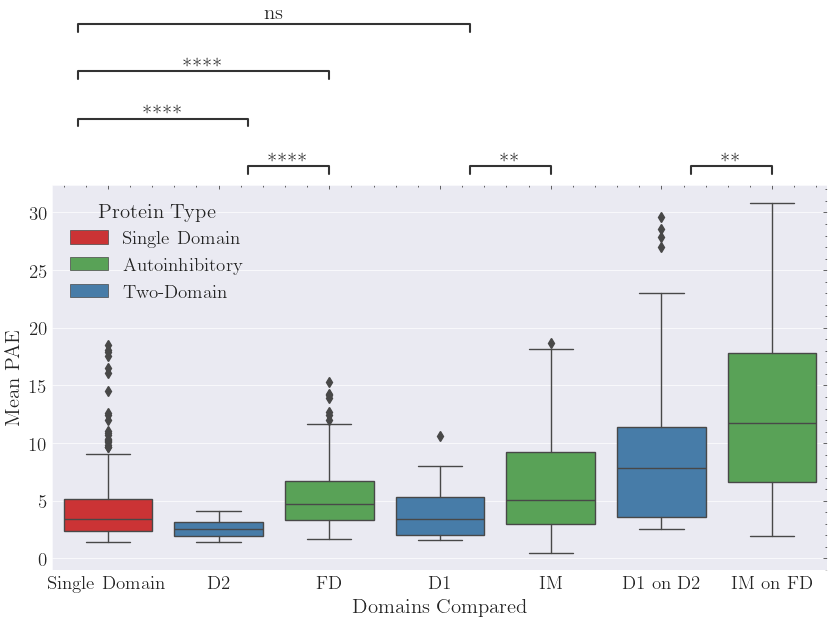

In [155]:
region_order = ['Single Domain', 'D2', 'FD', 'D1', 'IM', 'D1 on D2', 'IM on FD']

f, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=df_all, x='region', y='mean_pae', hue='type', order=region_order, ax=ax, palette=colors, dodge=False)
ax.set_xlabel('Domains Compared')
ax.set_ylabel('Mean PAE')
ax.legend(title='Protein Type')

# Annotate statistical significance

pairs = [[('Single Domain', 'Single Domain'), ('FD', 'Autoinhibitory')],
         [('Single Domain', 'Single Domain'), ('D2', 'Two-Domain')],
         [('Single Domain', 'Single Domain'), ('D1', 'Two-Domain')],
         [('FD', 'Autoinhibitory'), ('D2', 'Two-Domain')],
         [('IM', 'Autoinhibitory'), ('D1', 'Two-Domain')],
         [('IM on FD', 'Autoinhibitory'), ('D1 on D2', 'Two-Domain')]]
annotator = Annotator(ax, pairs, data=df_all, x='region', y='mean_pae', order=region_order, hue='type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', comparisons_correction="bonferroni")
_, corrected_results = annotator.apply_and_annotate()

# Save the figure
plt.savefig('./project_pipeline/data/figures/auto_sd_md_proteins_pae_annotated.png')

We'll make a table for all the types of our proteins

Single Domain     258
Autoinhibitory    123
Two-Domain         54
Name: type, dtype: int64


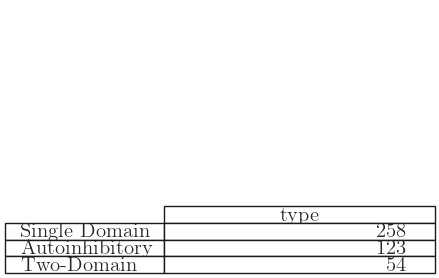

In [147]:
subAll = df_all[['uniprot', 'type']]
subAll = subAll.drop_duplicates()

# Get the number of proteins in each category
counts = subAll['type'].value_counts()
print(counts)

ax = plt.subplot(111, frame_on=False)
table(ax, counts)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plt.savefig('./project_pipeline/data/figures/auto_sd_md_proteins_pae_table.png')

# Plot for PAE of 2-State Autoinhibitory Proteins Compared to Single Domain and Two-Domain Proteins

Now we're going to look at 2-state autoinhibitory proteins

In [148]:
# Determine which proteins from cl have both active and autoinhibited structures
both = cl.groupby('uniprot').filter(lambda x: x['state'].nunique() > 1)

# Get the list of uniprots
uniprots = both['uniprot'].unique()

# Filter for these proteins in the pae dataframe
df_both_melt = df_pae_melt[df_pae_melt['uniprot'].isin(uniprots)]

# Merge the dataframes
df_all2 = pd.concat([df_single_melt, df_both_melt, df_multi_melt], ignore_index=True).drop_duplicates()
df_all2['mean_pae'] = df_all2['mean_pae'].astype('float')

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

D2_Two-Domain vs. FD_Autoinhibitory: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:2.163e-13 U_stat=9.430e+02
D1_Two-Domain vs. IM_Autoinhibitory: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.840e-03 U_stat=2.188e+03
D1 on D2_Two-Domain vs. IM on FD_Autoinhibitory: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:3.845e-03 U_stat=2.249e+03
Single Domain_Single Domain vs. D2_Two-Domain: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.899e-05 U_stat=9.776e+03
Single Domain_Single Domain vs. FD_Autoinhibitory: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.941e-05 U_stat=1.119e+04
Single Domain_Single Domain vs. D1_Two-Domain: Mann-Whitney-Wilcoxon test two-sided with Bonferro

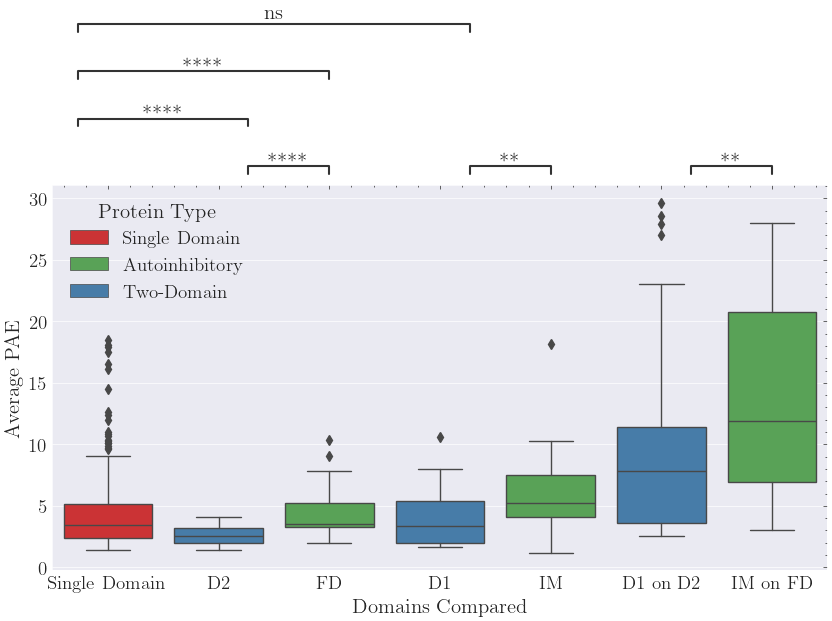

In [149]:
region_order = ['Single Domain', 'D2', 'FD', 'D1', 'IM', 'D1 on D2', 'IM on FD']

f, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=df_all2, x='region', y='mean_pae', hue='type', order=region_order, ax=ax, palette=colors, dodge=False)
ax.set_xlabel('Domains Compared')
ax.set_ylabel('Average PAE')
ax.legend(title='Protein Type')

# Annotate statistical significance

pairs = [[('Single Domain', 'Single Domain'), ('FD', 'Autoinhibitory')],
         [('Single Domain', 'Single Domain'), ('D2', 'Two-Domain')],
         [('Single Domain', 'Single Domain'), ('D1', 'Two-Domain')],
         [('FD', 'Autoinhibitory'), ('D2', 'Two-Domain')],
         [('IM', 'Autoinhibitory'), ('D1', 'Two-Domain')],
         [('IM on FD', 'Autoinhibitory'), ('D1 on D2', 'Two-Domain')]]
annotator = Annotator(ax, pairs, data=df_all, x='region', y='mean_pae', order=region_order, hue='type')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', comparisons_correction="bonferroni")
_, corrected_results = annotator.apply_and_annotate()

# Save the figure
plt.savefig('./project_pipeline/data/figures/auto2state_sd_md_proteins_pae_annotated.png')

Single Domain     258
Two-Domain         54
Autoinhibitory     18
Name: type, dtype: int64


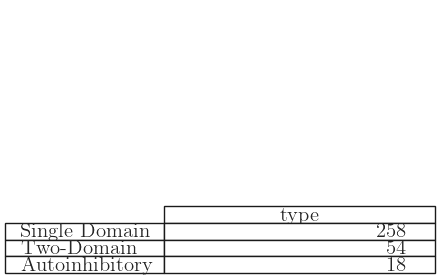

In [150]:
# And a table for these too
subAll = df_all2[['uniprot', 'type']]
subAll = subAll.drop_duplicates()

# Get the number of proteins in each category
counts = subAll['type'].value_counts()
print(counts)

ax = plt.subplot(111, frame_on=False)
table(ax, counts)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plt.savefig('./project_pipeline/data/figures/auto2state_sd_md_proteins_pae_table.png')

I would like to make my own visualization of the PAE matrix, so this is what this section is for.

In [198]:
sns.set_theme(font_scale=1.2)

# Read in the desired JSON matrix and format it to a dataframe
file = './project_pipeline/data/input/Alphafold_cif/F-O43739-F1-predicted_aligned_error_v3.json'
scores = json.loads(open(file).read())
pae = scores[0]['predicted_aligned_error']

df = pd.DataFrame(pae)
df.loc[max(df.index) + 1, :] = None
df.loc[:, max(df.columns) + 1] = None
df = df.shift(periods=1, axis=1)
df = df.shift(periods=1, axis=0)
df = df.drop(columns=0, index=0)
df.head()

,1,2,3,4,5,6,7,8,9,10,...,391,392,393,394,395,396,397,398,399,400
1,0.0,1.0,3.0,4.0,5.0,7.0,9.0,11.0,14.0,16.0,...,30.0,31.0,30.0,31.0,31.0,31.0,31.0,30.0,30.0,29.0
2,2.0,0.0,1.0,3.0,5.0,5.0,7.0,8.0,11.0,14.0,...,30.0,30.0,31.0,30.0,31.0,30.0,30.0,30.0,30.0,29.0
3,3.0,2.0,0.0,1.0,3.0,4.0,6.0,7.0,9.0,12.0,...,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,30.0
4,4.0,3.0,2.0,0.0,1.0,2.0,4.0,6.0,7.0,9.0,...,30.0,30.0,31.0,30.0,31.0,30.0,30.0,30.0,30.0,30.0
5,4.0,5.0,4.0,2.0,0.0,1.0,3.0,4.0,6.0,8.0,...,31.0,31.0,31.0,30.0,31.0,31.0,31.0,30.0,31.0,30.0


[Text(0, 1, '1'),
 Text(0, 50, '50'),
 Text(0, 100, '100'),
 Text(0, 150, '150'),
 Text(0, 200, '200'),
 Text(0, 250, '250'),
 Text(0, 300, '300'),
 Text(0, 350, '350'),
 Text(0, 400, '400')]

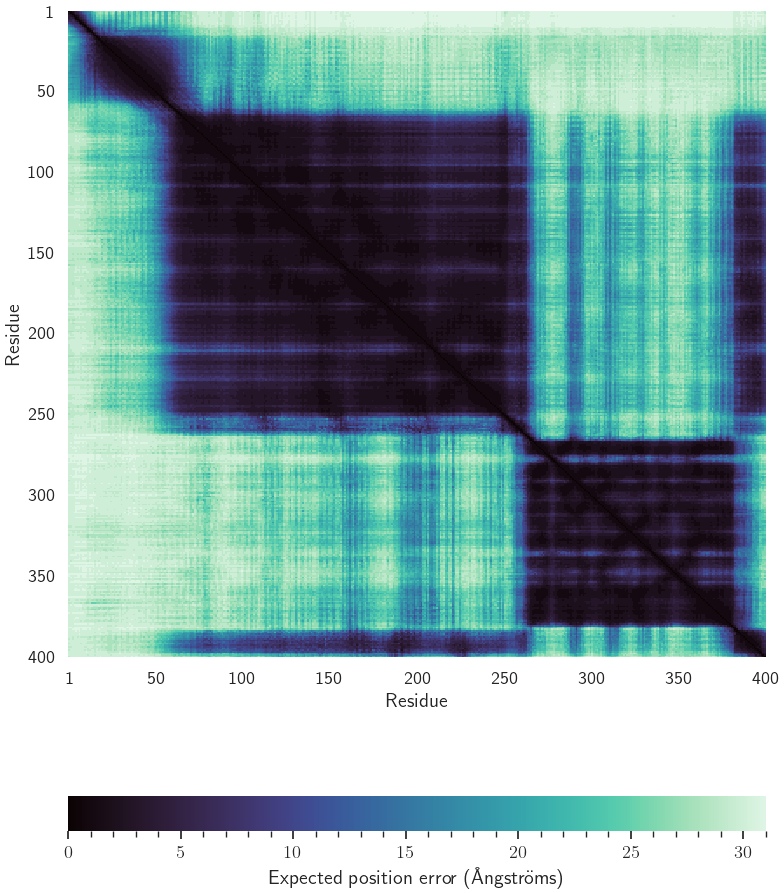

In [199]:

ticklabels = [1, 50, 100, 150, 200, 250, 300, 350, 400]

fig, ax = plt.subplots(figsize=(9, 12))
sns.heatmap(df, cmap='mako', ax=ax, cbar_kws={'label': 'Expected position error (Ångströms)', 'location': 'bottom'})
plt.tick_params(
    axis='both',
    which='both',
    bottom=False,
    left=False,
    top=False,
    right=False
)
ax.set_ylabel('Residue')
ax.set_xlabel('Residue')
ax.set_yticks(ticklabels)
ax.set_xticks(ticklabels)
ax.set_xticklabels((f'{x}' for x in ticklabels), rotation=0)
ax.set_yticklabels(f'{x}' for x in ticklabels)
# ax.set_xticks(ticklabels*ax.get_xlim()[1])
# ax.set_yticks(ticklabels*ax.get_ylim()[1])
# ax.xaxis.set_major_locator(plt.MaxNLocator(10))
# ax.yaxis.set_major_locator(plt.MaxNLocator(10))